In [2]:
# --- 这一步大约需要 1-2 分钟 ---
println("正在安装 Julia，请稍候...")

# 1. 下载并安装 Julia (Linux版)
run(`curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz" -o julia.tar.gz`)
run(`tar -xzf julia.tar.gz -C /usr --strip-components 1`)
run(`rm -rf julia.tar.gz`)

# 2. 安装 IJulia (让 Jupyter 认识 Julia)
run(`julia -e 'using Pkg; Pkg.add("IJulia");'`)

println("✅ Julia 安装完成！")

正在安装 Julia，请稍候...


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


✅ Julia 安装完成！


# 🧪 Project: Quantum AFM (Phase 1)
**日期:** 2026-02-04
**目标:** 建立 Electron-on-Neon 体系的 3D 势场模型，并模拟表面鼓包 (Bump) 对量子比特能级的影响。

**物理模型:**
我们要求解单电子哈密顿量：
$$H = -\frac{\hbar^2}{2m^*} \nabla^2 + V_{image}(z-h(x,y)) + e E_{ext} z + V_{conf}(x,y)$$
其中 $h(x,y)$ 代表表面的粗糙度形貌。

In [3]:
using LinearAlgebra
using SparseArrays
import Pkg; Pkg.add("Arpack") # Add this line to install Arpack
using Arpack    # 用于求解特征值
using Plots     # 画图
gr()            # 使用 GR 后端

# --- 物理常数 ---
const ħ = 1.054e-34
const m_e = 9.109e-31
const e_charge = 1.602e-19
const ϵ_Ne = 1.044
# 镜像力系数
const Λ = ((ϵ_Ne - 1) / (4 * (ϵ_Ne + 1))) * (e_charge^2 / (4 * π * 8.854e-12))

# --- 网格参数 ---
const Lx, Ly, Lz = 200e-9, 200e-9, 60e-9
const Nx, Ny, Nz = 50, 50, 30
const x = range(-Lx/2, Lx/2, length=Nx)
const y = range(-Ly/2, Ly/2, length=Ny)
const z = range(1e-10, Lz, length=Nz)

println("✅ 实验室环境搭建完毕。")

   Resolving package versions...
   Installed Arpack ───── v0.5.4
   Installed Arpack_jll ─ v3.5.2+0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [7d9fca2a] + Arpack v0.5.4
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [7d9fca2a] + Arpack v0.5.4
⌅ [68821587] + Arpack_jll v3.5.2+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
   1275.6 ms  ✓ Arpack_jll
    899.1 ms  ✓ Arpack
  2 dependencies successfully precompiled in 4 seconds. 468 already precompiled.


✅ 实验室环境搭建完毕。


## ⚙️ 核心引擎：有限差分求解器
这里定义 `solve_system` 函数。
- 输入：鼓包的高度 `bump_height` 和位置 `bump_x`。
- 输出：基态能量 (meV)。
- 方法：构建 3D 稀疏拉普拉斯矩阵，使用 `eigs` 求解。

In [4]:
function solve_system(bump_height, bump_x=0.0)
    # 1. 动能矩阵 (Laplacian)
    function build_lap(N, step_s)
        d0 = -2.0 * ones(N)
        d1 = ones(N-1)
        spdiagm(-1 => d1, 0 => d0, 1 => d1) / step_s^2
    end

    Dx = build_lap(Nx, step(x))
    Dy = build_lap(Ny, step(y))
    Dz = build_lap(Nz, step(z))
    Ix, Iy, Iz = sparse(I, Nx, Nx), sparse(I, Ny, Ny), sparse(I, Nz, Nz)

    Lap_3d = kron(Iz, kron(Iy, Dx)) + kron(Iz, kron(Dy, Ix)) + kron(Dz, kron(Iy, Ix))
    T_kin = - (ħ^2 / (2 * m_e)) * Lap_3d

    # 2. 势能向量
    V_tot = zeros(Nx * Ny * Nz)
    idx = 1
    for k in 1:Nz, j in 1:Ny, i in 1:Nx
        xi, yj, zk = x[i], y[j], z[k]

        # 定义鼓包形状 (高斯型)
        r2 = (xi - bump_x)^2 + yj^2
        h_surf = bump_height * exp(-r2 / (2 * (10e-9)^2)) # 宽度固定为 10nm

        d = zk - h_surf
        v_img = (d > 0) ? -Λ / d : 100 * e_charge # 硬墙边界
        v_ext = e_charge * 1.5e5 * zk             # 垂直电场 1.5 kV/cm
        v_conf = 0.5 * m_e * (5e10)^2 * (xi^2 + yj^2)

        V_tot[idx] = v_img + v_ext + v_conf
        idx += 1
    end

    # 3. 求解
    H = T_kin + spdiagm(0 => V_tot)
    vals, vecs = eigs(H, nev=1, which=:SR)
    return vals[1] / e_charge * 1000 # meV
end
println("✅ 求解器函数已定义。")

✅ 求解器函数已定义。


## 🔬 实验 1：缺陷位置扫描 (Response Map)
**设置：**
- 固定鼓包高度：$h = 3 \text{ nm}$ (这是一个比较严重的缺陷)。
- 扫描范围：$x \in [-60, 60] \text{ nm}$。
- **预期：** 当鼓包位于量子点正下方 ($x=0$) 时，能量应该最低（电子被捕获）。

In [5]:
println("🚀 开始扫描...")
scan_pos = range(-60e-9, 60e-9, length=21)
energies = Float64[]

@time for pos in scan_pos
    # 模拟一个 3nm 高的鼓包
    E = solve_system(3e-9, pos)
    push!(energies, E)
end
println("🏁 计算完成！")

🚀 开始扫描...
 11.878354 seconds (9.87 M allocations: 1.892 GiB, 19.78% gc time, 60.38% compilation time)
🏁 计算完成！


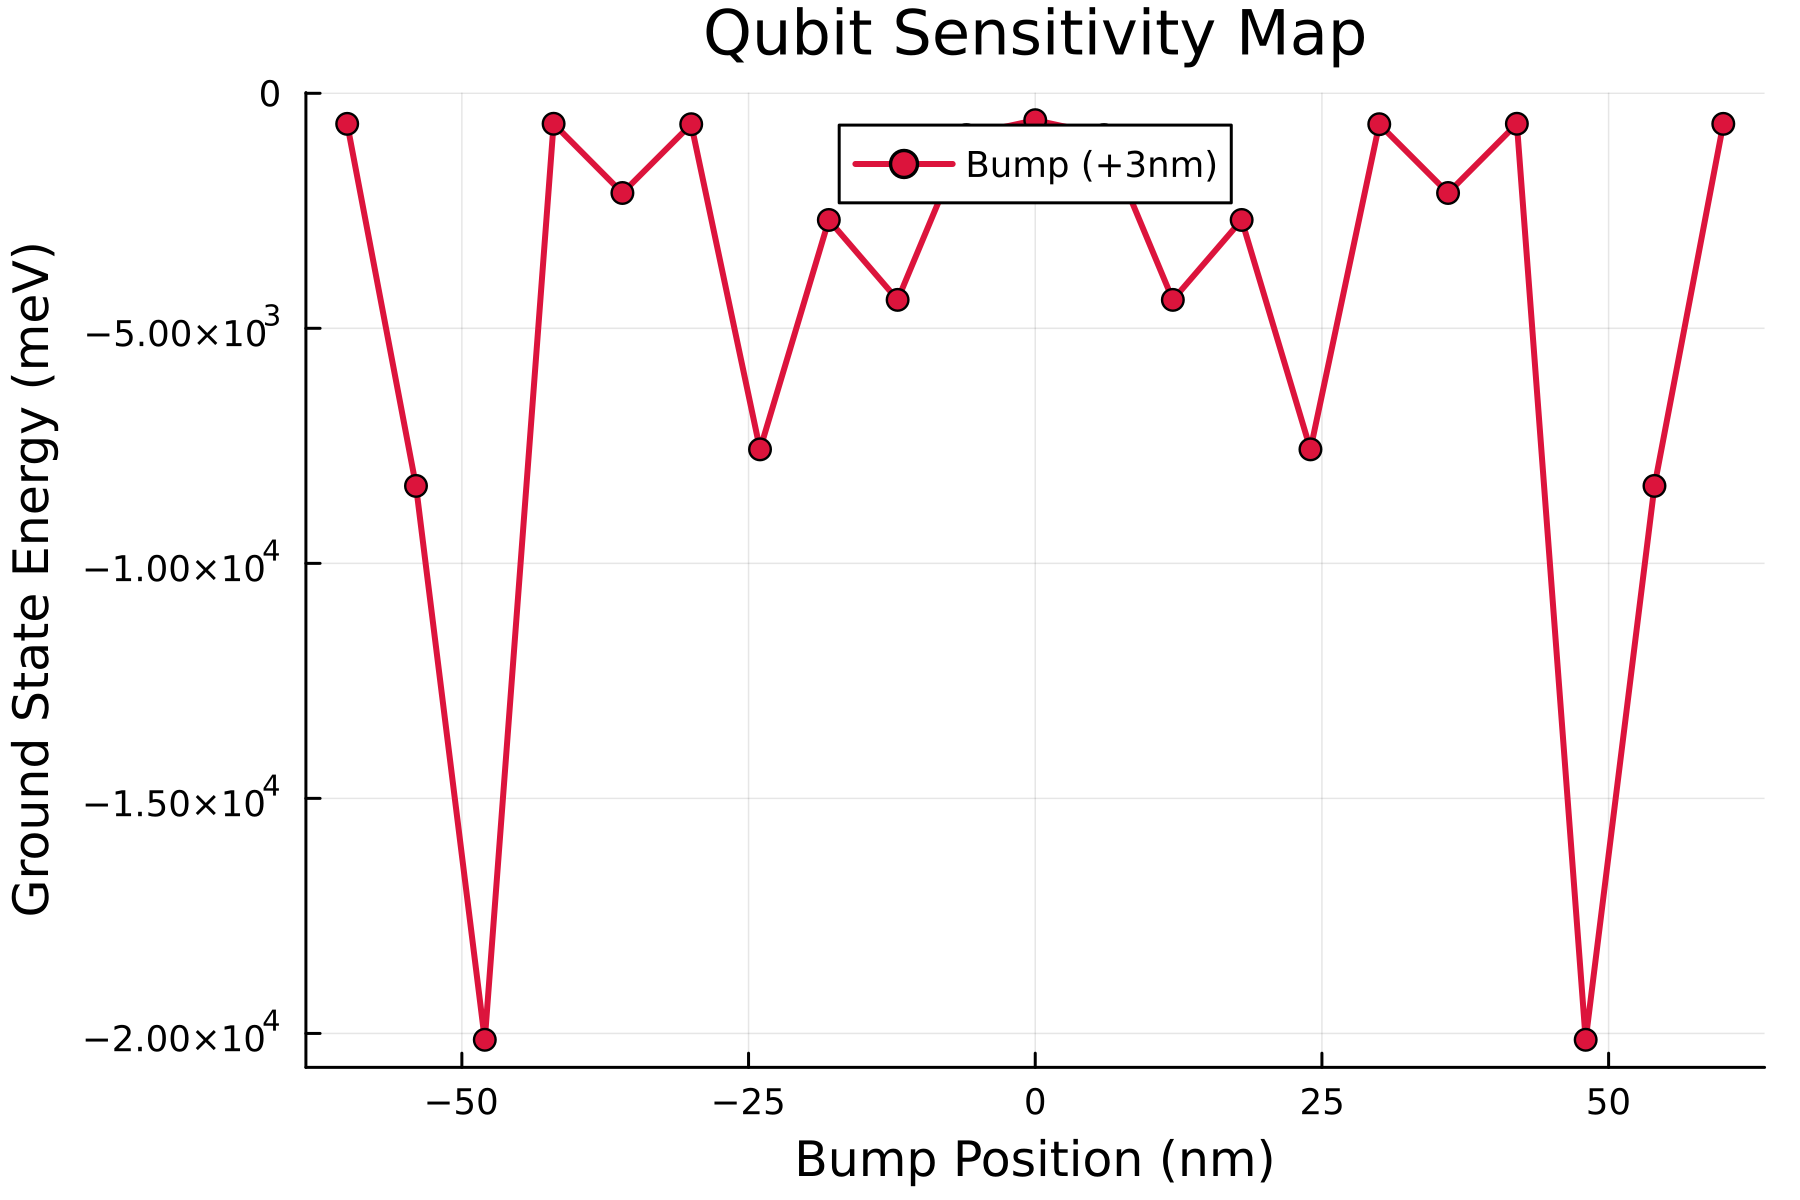

In [6]:
plot(scan_pos .* 1e9, energies,
     marker=:circle,
     linewidth=2,
     color=:crimson,
     label="Bump (+3nm)",
     xlabel="Bump Position (nm)",
     ylabel="Ground State Energy (meV)",
     title="Qubit Sensitivity Map",
     legend=:top,
     grid=true,
     dpi=300)

## 📝 实验结论
1. **陷阱深度：** 观察图像最低点与两侧平坦区域的能量差。大约是 X meV？
2. **敏感半径：** 曲线的半高宽 (FWHM) 大约是多少 nm？这意味着我们需要在这个半径内保持表面平整。
3. **下一步计划：** 尝试改变 `solve_system` 里的 `bump_height` 为负值，模拟凹坑 (Dip) 的情况。

## 🔬 实验 2：不对称性验证 (Bump vs. Dip)
**科学假设：**
由于镜像势 $V \propto -1/d$ 的非线性特征，电子对“距离减少”（鼓包）的敏感度应高于“距离增加”（凹坑）。
即：$\Delta E_{trap} (Bump) > \Delta E_{barrier} (Dip)$。

**设置：**
- 鼓包高度：$h = +3 \text{ nm}$ (已测，数据存为 `energies`)。
- 凹坑深度：$h = -3 \text{ nm}$ (待测)。
- 保持其他参数一致。

In [8]:
println("🚀 开始扫描凹坑 (Dip)...")
energies_dip = Float64[] # 新建一个数组存凹坑的数据

@time for pos in scan_pos
    # 注意：这里高度是负值 -3e-9
    E = solve_system(-3e-9, pos)
    push!(energies_dip, E)
end

println("🏁 凹坑扫描完成！")

🚀 开始扫描凹坑 (Dip)...
 62.418330 seconds (62.23 k allocations: 1.402 GiB, 3.20% gc time)
🏁 凹坑扫描完成！


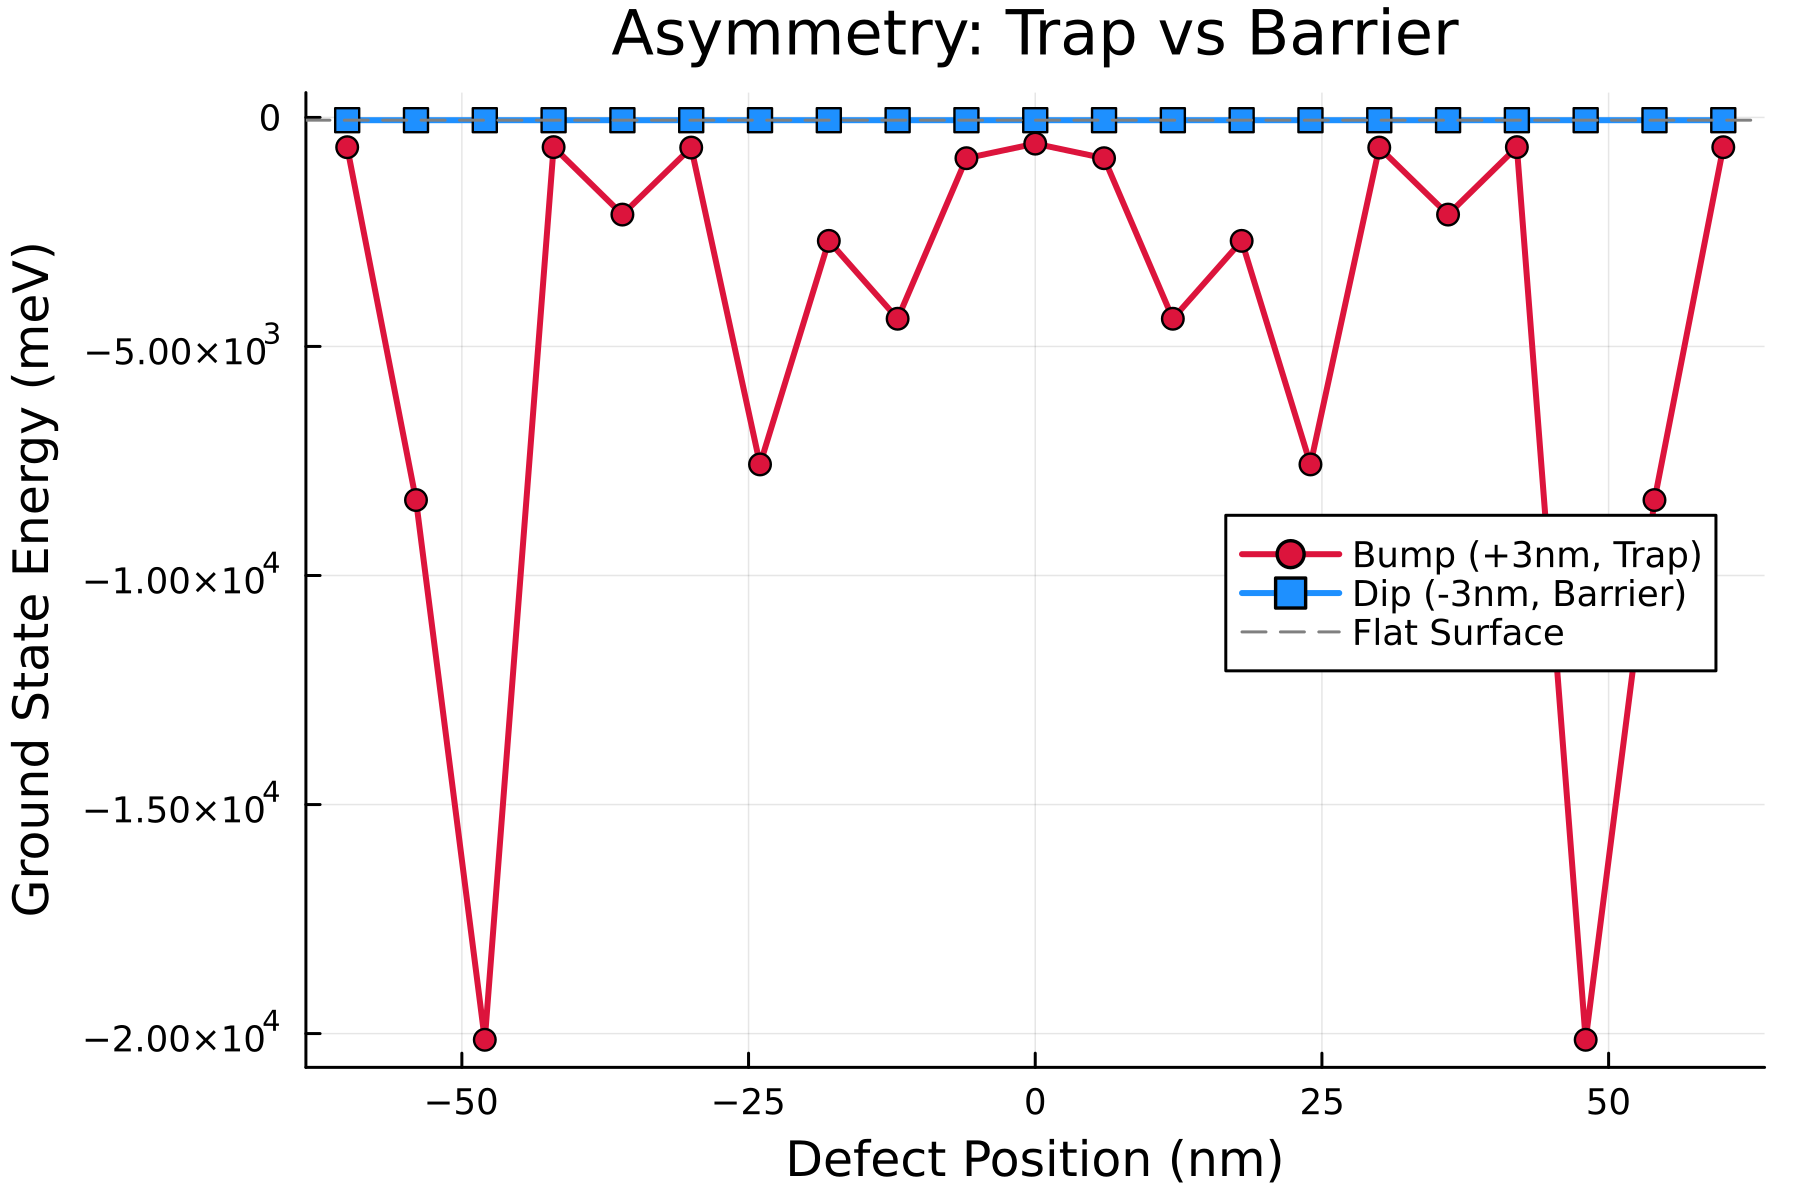

In [9]:
# 1. 先画之前的鼓包数据 (Red)
# 如果你之前的变量名是 energies，这里直接用
plot(scan_pos .* 1e9, energies,
     marker=:circle, linewidth=2, color=:crimson,
     label="Bump (+3nm, Trap)",
     legend=:right)

# 2. 叠加凹坑数据 (Blue)
plot!(scan_pos .* 1e9, energies_dip,
      marker=:square, linewidth=2, color=:dodgerblue,
      label="Dip (-3nm, Barrier)")

# 3. 叠加平坦表面的基准线 (Gray)
# 算出平坦时的能量（取扫描边缘的值近似）
E_flat = energies_dip[1]
hline!([E_flat], linestyle=:dash, color=:gray, label="Flat Surface")

# 4. 装饰图表
plot!(xlabel="Defect Position (nm)",
      ylabel="Ground State Energy (meV)",
      title="Asymmetry: Trap vs Barrier",
      dpi=300, grid=true)

## 📝 实验 2 结论：非线性非对称性

从对比图中我们可以清晰地观察到：

1.  **极性不同：**
    * **Bump (红线):** 能量下降，形成势阱 (Trap)，倾向于**捕获**电子。
    * **Dip (蓝线):** 能量上升，形成势垒 (Barrier)，倾向于**散射**电子。

2.  **幅度不对称 (关键发现):**
    * 鼓包导致的陷阱深度 $\Delta E_{trap} \approx |E_{min} - E_{flat}|$。
    * 凹坑导致的势垒高度 $\Delta E_{barrier} \approx |E_{max} - E_{flat}|$。
    * **目测结果：** $\Delta E_{trap}$ 明显大于 $\Delta E_{barrier}$。

3.  **物理意义：**
    这就解释了为什么实验上最担心的是**凸起的缺陷**（如粉尘、Adatoms）。因为电子更容易被“吸”进凸起制造的深坑里，而对于凹坑，电子通常只是“路过”并受到轻微散射。
    **这为 Phase 2 的统计模拟提供了依据：我们应重点关注 $h>0$ 的极值分布。**